In [107]:
import requests
import plaid
from plaid.model.link_token_create_request import LinkTokenCreateRequest
from plaid.model.link_token_create_request_user import LinkTokenCreateRequestUser
from plaid.model.products import Products
from plaid.model.country_code import CountryCode
from plaid.api import plaid_api
host = plaid.Environment.Sandbox

# Replace with your Plaid API credentials
PLAID_CLIENT_ID = '6574857728575f001c67f5d9'
PLAID_SECRET = '7ecc18ddda654fdf2971518e33c19c'

# Plaid API endpoint for creating a link token
PLAID_API_URL = 'https://sandbox.plaid.com/link/token/create'

# Parameters for the API request
# Account filtering isn't required here, but sometimes 
# it's helpful to see an example. 
configuration = plaid.Configuration(
    host=host,
    api_key={
        'clientId': PLAID_CLIENT_ID,
        'secret': PLAID_SECRET
    }
)

api_client = plaid.ApiClient(configuration)
client = plaid_api.PlaidApi(api_client)

request = LinkTokenCreateRequest(
  user=LinkTokenCreateRequestUser(
    client_user_id='user-id',
  ),
  client_name='BudgetBuddy',
  products=[Products('transactions')],
  country_codes=[CountryCode('US')],
  language='en',
  )

# create link token
# response = client.link_token_create(request)
# link_token = response['link_token']
# params = {
    
#     'client_id': PLAID_CLIENT_ID,
#     'secret': PLAID_SECRET,

#     'user': {
#         'client_user_id': '6574857728575f001c67f5d9',  # Replace with your user ID
#     },
#     'products': ['transactions'],
# }

# Make the API request to obtain the link token
# response = requests.post(PLAID_API_URL, json=params)
try:
    response = client.link_token_create(request)
    data = response.to_dict()  # Assuming Plaid's response has a to_dict method
    link_token = data.get('link_token')
# Handle the response
    if link_token:
        print(f"Link Token: {link_token}")
    else:
        print(f"Error: Link Token not present in the response data")
except plaid.ApiException as e:
    error_data = json.loads(e.body)
    print(f"Error: {error_data['error_code']} - {error_data['error_message']}")
link_token = 'link-sandbox-944b097f-fb64-40a7-9d1d-6a2ee719ba71'

Link Token: link-sandbox-4afed49a-1a1f-4f9e-b724-63fb14dd8743


In [108]:
from plaid.model.sandbox_public_token_create_request import SandboxPublicTokenCreateRequest
from plaid.model.item_public_token_exchange_request import  ItemPublicTokenExchangeRequest
pt_request = SandboxPublicTokenCreateRequest(
    institution_id='ins_109508',
    initial_products=[Products('transactions')]
)
pt_response = client.sandbox_public_token_create(pt_request)
# The generated public_token can now be
# exchanged for an access_token
exchange_request = ItemPublicTokenExchangeRequest(
    public_token=pt_response['public_token']
)
exchange_response = client.item_public_token_exchange(exchange_request)

In [109]:
from plaid.model.transactions_sync_request import TransactionsSyncRequest
# Provide a cursor from your database if you've previously
# received one for the Item. Leave null if this is your
# first sync call for this Item. The first request will
# return a cursor.
transactions_db = []
latest_cursor_db = {}
def get_latest_cursor_or_none(item_id):
    return latest_cursor_db.get(item_id, '')
added = [2]
modified = []
removed = [] # Removed transaction ids
def apply_updates(item_id, added, modified, removed, cursor):
    global transactions_db
    transactions_db.extend(added)
    transactions_db = [t for t in transactions_db if t not in removed]
    
    # Update the latest cursor for the item
    latest_cursor_db[item_id] = cursor

item_id = 'lPzPaPak5GHm3NQWBMVRhorZKZ3K6zSZGBbrd'
latest_cursor = get_latest_cursor_or_none(item_id)
# New transaction updates since "cursor"

has_more = True

# Iterate through each page of new transaction updates for item
while has_more:
  request = TransactionsSyncRequest(
    access_token=exchange_response['access_token'],
    cursor=latest_cursor,
  )
  response = client.transactions_sync(request)

  # Add this page of results
  added.extend(response['added'])
  modified.extend(response['modified'])
  removed.extend(response['removed'])

  has_more = response['has_more']

  # Update cursor to the next cursor
  latest_cursor = response['next_cursor']

# Persist cursor and updated data
apply_updates(item_id, added, modified, removed, latest_cursor)


Category,ENTERTAINMENT,FOOD_AND_DRINK,GENERAL_MERCHANDISE,GENERAL_SERVICES,INCOME,LOAN_PAYMENTS,PERSONAL_CARE,TRANSPORTATION,TRAVEL
date,,,,,,,,,
9,NaN,NaN,1000.0,5850.0,NaN,25.0,NaN,5.40,NaN
10,500.0,516.33,3667.9,5850.0,-4.22,25.0,78.5,11.73,0.0
11,589.4,516.33,2578.5,5850.0,-4.22,NaN,78.5,6.33,0.0
12,500.0,500.00,2578.5,5850.0,NaN,NaN,NaN,NaN,500.0


<Axes: xlabel='date'>

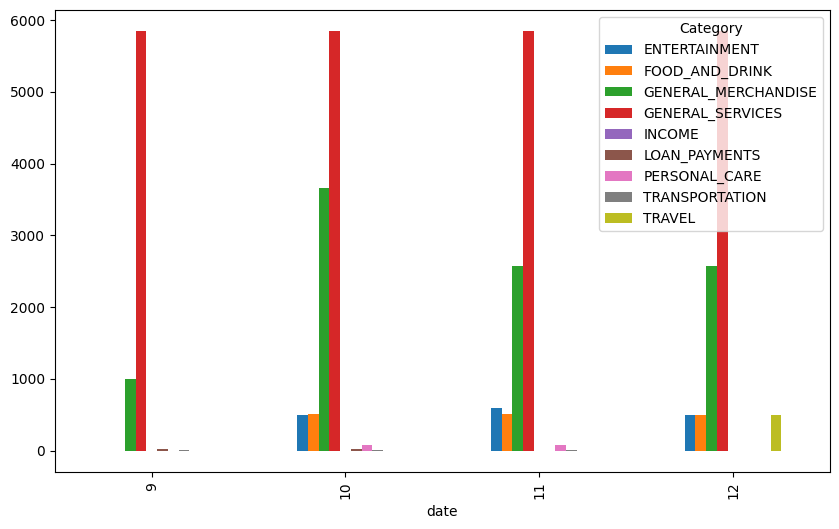

In [110]:
import pandas as pd
import datetime
%run transaction_data.py

df = pd.json_normalize(data)
df['date'] = pd.to_datetime(df['date'])
df=df[['amount','personal_finance_category.primary','personal_finance_category.detailed','date']]

# group by month and category
monthly_flow=df.groupby([df['date'].dt.month, 'personal_finance_category.primary'])['amount'].sum().unstack()
monthly_flow = monthly_flow.rename_axis(columns='Category')

display(monthly_flow)
monthly_flow.plot(kind='bar', legend=True, 
                  figsize=(10, 6),
                 )

In [111]:
#set budget
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, interact
import matplotlib.pyplot as plt

categories = ['ENTERTAINMENT', 'FOOD_AND_DRINK', 'GENERAL_MERCHANDISE', 'GENERAL_SERVICES', 'LOAN_PAYMENTS', 'PERSONAL_CARE', 'TRANSPORTATION', 'TRAVEL']
slider_data=[{'Category':category, 'Budget': 0} for category in categories]
df = pd.DataFrame(slider_data, columns=['Category', 'Budget'])

def on_slider_change(**kwargs):
    global df
    category = kwargs['category']
    new_value = kwargs['budget']
    df.loc[df['Category'] == category, 'Budget'] = new_value

    print("Selected value:", new_value)
    print("")
    print(df)
    
interactive_plot = interactive(on_slider_change, category=categories, budget=widgets.IntText(
    value=0,
    style={'description_width': 'initial'},
    ))
display(interactive_plot)


interactive(children=(Dropdown(description='category', options=('ENTERTAINMENT', 'FOOD_AND_DRINK', 'GENERAL_ME…

Category,ENTERTAINMENT,FOOD_AND_DRINK,GENERAL_MERCHANDISE,GENERAL_SERVICES,INCOME,LOAN_PAYMENTS,PERSONAL_CARE,TRANSPORTATION,TRAVEL
date,,,,,,,,,
9,NaN,NaN,1000.0,5850.0,NaN,25.0,NaN,5.40,NaN
10,500.0,516.33,3667.9,5850.0,-4.22,25.0,78.5,11.73,0.0
11,589.4,516.33,2578.5,5850.0,-4.22,NaN,78.5,6.33,0.0
12,500.0,500.00,2578.5,5850.0,NaN,NaN,NaN,NaN,500.0


Category,ENTERTAINMENT,FOOD_AND_DRINK,GENERAL_MERCHANDISE,GENERAL_SERVICES,LOAN_PAYMENTS,PERSONAL_CARE,TRANSPORTATION,TRAVEL
Budget,0,0,0,0,0,0,0,0


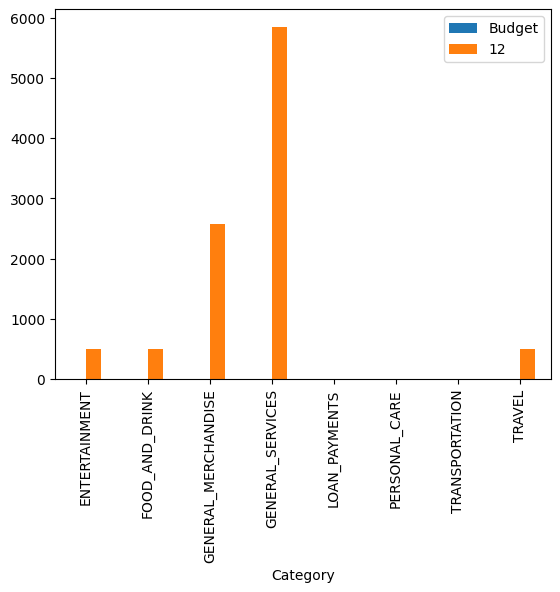

In [112]:
#monthly overview with budget
budget_transpose=df.transpose()
budget_transpose.columns=budget_transpose.loc['Category']
budget_transpose=budget_transpose.drop('Category')
display(monthly_flow)
display(budget_transpose)

def monthly_view_with_budget(month):
    merge=pd.merge(budget_transpose.T, monthly_flow.loc[month].T, on='Category')
    merge.plot(kind='bar')
monthly_view_with_budget(12)